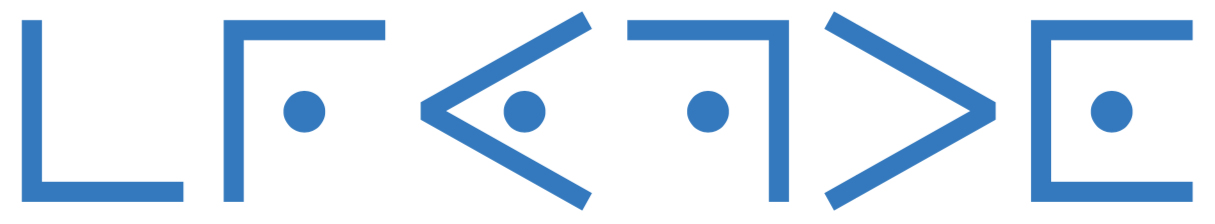

# TP3. Cryptographie appliquée

Dans ce TP nous travaillerons en Python 3, directement à l'intérieur de ce notebook jupyter.

Nous avons choisi d'utiliser la bibliothèque [PyCryptodome](http://www.pycryptodome.org/). Pour rejouer cette fiche en dehors du TP, il  convient d'installer une version récente de [PyCryptodome](http://www.pycryptodome.org/) sur votre système.

L'objectif du TP est d'expérimenter des éléments vus en cours et en TD dans deux cas pratique. Ces deux exemples sont inspirés du Challenge de crypto 2019/2020.

## 1. Chiffrement de VPN avec IPSec

[IPsec](http://fr.wikipedia.org/wiki/Internet_Protocol_Security) offre un mécanisme normalisé et donc interopérable de chiffrement des données en mode host-to-host ou lan-to-lan (avec tunnel). L'ensemble des RFCs décrivant IPsec est touffu, on se contentera de lire dans un premier temps la [page Wikipedia IPsec](http://en.wikipedia.org/wiki/IPsec) et dans un second temps seulement [An Illustrated Guide to IPsec](http://www.unixwiz.net/techtips/iguide-ipsec.html).

Le protocole [IKE](https://fr.wikipedia.org/wiki/Internet_Key_Exchange) permet de négocier les paramètres de connexion. C'est la bonne manière d'utiliser IPSec. Dans ce TP, afin de nous focaliser sur le mécanisme de chiffrement des paquets, nous avons opté pour une configuration statique du VPN en manipulant directement la configuration noyau à l'aide de la commande `ip`.

Dans cet exercice, il s'agit de comprendre les grands principes d'IPSec afin de décoder des échanges réseau chiffrés à partir de la connaissance des paramètres cryptographiques utilisés. En effet, l'avantage d'un protocole normalisé est d'être débugable, ici à l'aide de [Wireshark](https://www.wireshark.org).


Téléchargez le [fichier pcap](https://pdicost.univ-orleans.fr/cryptodm/micmac.php?user=110&data=7&apikey=ee6d2b7a1338ded6267165f91b5a860643f5df5442e2885584b17841d8e7bb6f) à ouvrir dans Wireshark.

L'objectif est de pouvoir accéder au contenu en clair des paquets comme sur la copie d'écran ci-dessous.

PS. Le fichier pcap correspond à une écoute sur toutes les interfaces d'un routeur intermédiaire, chaque trame apparait donc dupliquée. Pour que ce soit plus lisible, vous pouvez par exemple utiliser le même filtre que sur la copie d'écran.

![une fois déchiffré](https://pdicost.univ-orleans.fr/cryptodm/micmac.php?user=110&data=8&apikey=037f1e32a51ef99c259f0271c0d6366fa136ce7e1e8b615317969f70a6ca572c)

Voici le script qui a été utilisé pour configurer un des routeurs qui mettent en place le tunnel IPSec.


```bash
#!/bin/sh
####### STATE
ip xfrm state flush
ip xfrm state add src 100.10.10.10 dst 100.20.20.20 \
	proto esp spi 0x539 mode tunnel \
	enc "cbc(aes)" "micmac is sha256" \
	auth-trunc "hmac(md5)" "(K+M) which is v" 96
ip xfrm state add src 100.20.20.20 dst 100.10.10.10 \
	proto esp spi 0x539 mode tunnel \
	enc "cbc(aes)" "ulnerable to len" \
	auth-trunc "hmac(md5)" "gth extension at" 96
###### POLICY
ip xfrm policy flush
ip xfrm policy add src 192.168.2.0/24 dst 192.168.1.0/24 \
	dir fwd tmpl src 100.20.20.20 dst 100.10.10.10 \
		proto esp mode tunnel
ip xfrm policy add src 192.168.2.0/24 dst 192.168.1.0/24 \
	dir in tmpl src 100.20.20.20 dst 100.10.10.10 \
		proto esp mode tunnel
ip xfrm policy add src 192.168.1.0/24 dst 192.168.2.0/24 \
	dir out tmpl src 100.10.10.10 dst 100.20.20.20 \
		proto esp mode tunnel

```

In [3]:
On clique sur une ligne
"preference du protocole" > "frame" > "open frame preference"
on selection le portocole "esp"
on coche case pour "detect/decode", puis ajoute "edit"
on ajoute les 2 lignes en fonction du script d avant

apres on peut faire click droit> suivre> tcp et on voit la conv


SyntaxError: invalid syntax (<ipython-input-3-5939bd3ab713>, line 1)

En vous aidant de la [documentation de Wireshark sur l'écoute IPSec](https://gitlab.com/wireshark/wireshark/-/wikis/ESP_Preferences), déchiffrez l'échange TCP entre Alice et Bob !


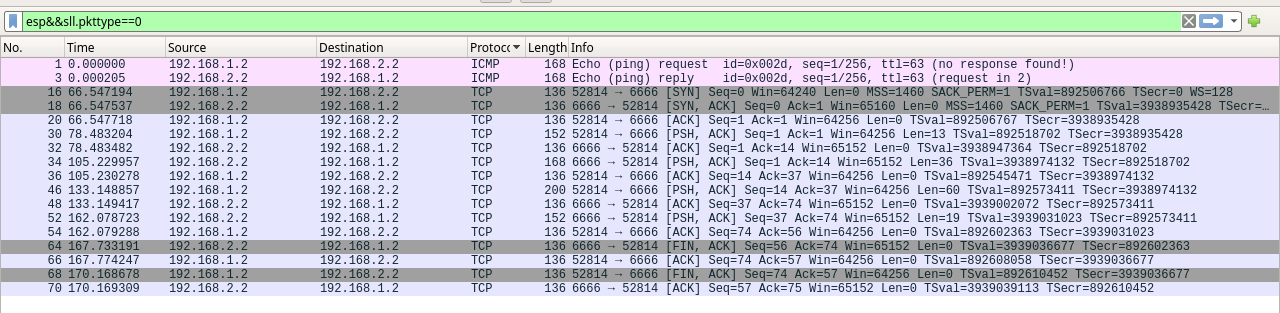

## 2. Qu'est-ce que c'est que ce micmac ?

Observez les URLs utilisées pour obtenir le fichier pcap et les copies d'écran ci-dessus, par exemple `https://pdicost.univ-orleans.fr/cryptodm/micmac.php?user=110&data=8&apikey=037f1e32a51ef99c259f0271c0d6366fa136ce7e1e8b615317969f70a6ca572c`

Elles sont servies par un script PHP dont voici le code source :


```
<?php
  //////////////////////////////////////////////////
  // Da micmac (wanabe) secure data API.          //
  // Share files that have been approved by user. //
  //////////////////////////////////////////////////
  function fail() { header('HTTP/1.0 403 Forbidden'); header('Content-Type: text/plain'); echo "Access Denied\n"; exit; }
  function get($k) { return isset($_GET[$k]) ? $_GET[$k] : fail(); }
  // We want file $data for user $user with API key $apikey
  $user=intval(get('user'));
  $data=intval(get('data'));
  $h=get('apikey');
  // Fetch $user secret API generation key
  $db=new SQLite3('/var/www/db/micmacdb');
  $st=$db->prepare('SELECT secret FROM users WHERE user = :user');
  $st->bindParam(':user',$user);
  $res=$st->execute();
  $secret="FAIL";
  while($x = $res->fetchArray(SQLITE3_NUM)) $secret=hex2bin($x[0]);
  if (strlen($secret) !== 32) fail();
  // Check if the API key is correct for that URL
  $s=urldecode($_SERVER['QUERY_STRING']);
  $pos=strpos($s, "&apikey=");
  if ($pos !== false) {
      $h=substr($s,$pos+8);
      $s=substr($s,0,$pos);
  }
  $hh=hash('sha256',$secret . $s);
  if (strcmp($h,$hh) !== 0) fail();
  // Ok we are good, we can provide the data if it exists in the DB
  $st=$db->prepare('SELECT mimetype FROM files WHERE rowid = :data');
  $st->bindParam(':data',$data);
  $res=$st->execute();
  $mimetype=FALSE;
  while($x = $res->fetchArray(SQLITE3_NUM)) { $mimetype=$x[0]; }
  if ($mimetype === FALSE) fail();
  $f=$db->openBlob('files', 'content', $data);
  header('Content-Type: ' . $mimetype);
  while(!feof($f)) echo fread($f,8192);
  fclose($f);
?>
```

Les URLs sont du type `https://pdicost.univ-orleans.fr/cryptodm/micmac.php?user=👩‍🦰&data=#️⃣&apikey=🍰` où le champ `apikey` contient en hexadécimal la valeur `SHA256(K+M)` avec `K` un secret de 32 octets et `M` la chaîne `user=👩‍🦰&data=#️⃣` (du caractère qui suit le `?` jusqu'au pied de `&apikey`).

Comme nous l'avons vu en cours, une attaque par extension de longueur est possible sur `SHA256`. Ici, elle va nous permettre d'accéder à toutes les paires de valeur `(user,data)` que l'on souhaite en construisant des URLs de la forme : `https://pdicost.univ-orleans.fr/cryptodm/micmac.php?user=👩‍🦰&data=#️⃣PADDING&data=NOUVELLEVALEUR&apikey=NOUVEAUMICMAC`.

À vous de jouer : trouvez une URL valide pour accéder à la ressource `user=54&data=3`.


Pour vous aider dans votre tâche, voici le code source d'une mise en œuvre en Python de SHA256.

In [4]:
SHA_BLOCKSIZE = 64
SHA_DIGESTSIZE = 32


def new_shaobject():
    return {
        'digest': [0]*8,
        'count_lo': 0,
        'count_hi': 0,
        'data': [0]* SHA_BLOCKSIZE,
        'local': 0,
        'digestsize': 0
    }

ROR = lambda x, y: (((x & 0xffffffff) >> (y & 31)) | (x << (32 - (y & 31)))) & 0xffffffff
Ch = lambda x, y, z: (z ^ (x & (y ^ z)))
Maj = lambda x, y, z: (((x | y) & z) | (x & y))
S = lambda x, n: ROR(x, n)
R = lambda x, n: (x & 0xffffffff) >> n
Sigma0 = lambda x: (S(x, 2) ^ S(x, 13) ^ S(x, 22))
Sigma1 = lambda x: (S(x, 6) ^ S(x, 11) ^ S(x, 25))
Gamma0 = lambda x: (S(x, 7) ^ S(x, 18) ^ R(x, 3))
Gamma1 = lambda x: (S(x, 17) ^ S(x, 19) ^ R(x, 10))

def sha_transform(sha_info):
    W = []
    
    d = sha_info['data']
    for i in range(0,16):
        W.append( (d[4*i]<<24) + (d[4*i+1]<<16) + (d[4*i+2]<<8) + d[4*i+3])
    
    for i in range(16,64):
        W.append( (Gamma1(W[i - 2]) + W[i - 7] + Gamma0(W[i - 15]) + W[i - 16]) & 0xffffffff )
    
    ss = sha_info['digest'][:]
    
    def RND(a,b,c,d,e,f,g,h,i,ki):
        t0 = h + Sigma1(e) + Ch(e, f, g) + ki + W[i];
        t1 = Sigma0(a) + Maj(a, b, c);
        d += t0;
        h  = t0 + t1;
        return d & 0xffffffff, h & 0xffffffff
    
    ss[3], ss[7] = RND(ss[0],ss[1],ss[2],ss[3],ss[4],ss[5],ss[6],ss[7],0,0x428a2f98);
    ss[2], ss[6] = RND(ss[7],ss[0],ss[1],ss[2],ss[3],ss[4],ss[5],ss[6],1,0x71374491);
    ss[1], ss[5] = RND(ss[6],ss[7],ss[0],ss[1],ss[2],ss[3],ss[4],ss[5],2,0xb5c0fbcf);
    ss[0], ss[4] = RND(ss[5],ss[6],ss[7],ss[0],ss[1],ss[2],ss[3],ss[4],3,0xe9b5dba5);
    ss[7], ss[3] = RND(ss[4],ss[5],ss[6],ss[7],ss[0],ss[1],ss[2],ss[3],4,0x3956c25b);
    ss[6], ss[2] = RND(ss[3],ss[4],ss[5],ss[6],ss[7],ss[0],ss[1],ss[2],5,0x59f111f1);
    ss[5], ss[1] = RND(ss[2],ss[3],ss[4],ss[5],ss[6],ss[7],ss[0],ss[1],6,0x923f82a4);
    ss[4], ss[0] = RND(ss[1],ss[2],ss[3],ss[4],ss[5],ss[6],ss[7],ss[0],7,0xab1c5ed5);
    ss[3], ss[7] = RND(ss[0],ss[1],ss[2],ss[3],ss[4],ss[5],ss[6],ss[7],8,0xd807aa98);
    ss[2], ss[6] = RND(ss[7],ss[0],ss[1],ss[2],ss[3],ss[4],ss[5],ss[6],9,0x12835b01);
    ss[1], ss[5] = RND(ss[6],ss[7],ss[0],ss[1],ss[2],ss[3],ss[4],ss[5],10,0x243185be);
    ss[0], ss[4] = RND(ss[5],ss[6],ss[7],ss[0],ss[1],ss[2],ss[3],ss[4],11,0x550c7dc3);
    ss[7], ss[3] = RND(ss[4],ss[5],ss[6],ss[7],ss[0],ss[1],ss[2],ss[3],12,0x72be5d74);
    ss[6], ss[2] = RND(ss[3],ss[4],ss[5],ss[6],ss[7],ss[0],ss[1],ss[2],13,0x80deb1fe);
    ss[5], ss[1] = RND(ss[2],ss[3],ss[4],ss[5],ss[6],ss[7],ss[0],ss[1],14,0x9bdc06a7);
    ss[4], ss[0] = RND(ss[1],ss[2],ss[3],ss[4],ss[5],ss[6],ss[7],ss[0],15,0xc19bf174);
    ss[3], ss[7] = RND(ss[0],ss[1],ss[2],ss[3],ss[4],ss[5],ss[6],ss[7],16,0xe49b69c1);
    ss[2], ss[6] = RND(ss[7],ss[0],ss[1],ss[2],ss[3],ss[4],ss[5],ss[6],17,0xefbe4786);
    ss[1], ss[5] = RND(ss[6],ss[7],ss[0],ss[1],ss[2],ss[3],ss[4],ss[5],18,0x0fc19dc6);
    ss[0], ss[4] = RND(ss[5],ss[6],ss[7],ss[0],ss[1],ss[2],ss[3],ss[4],19,0x240ca1cc);
    ss[7], ss[3] = RND(ss[4],ss[5],ss[6],ss[7],ss[0],ss[1],ss[2],ss[3],20,0x2de92c6f);
    ss[6], ss[2] = RND(ss[3],ss[4],ss[5],ss[6],ss[7],ss[0],ss[1],ss[2],21,0x4a7484aa);
    ss[5], ss[1] = RND(ss[2],ss[3],ss[4],ss[5],ss[6],ss[7],ss[0],ss[1],22,0x5cb0a9dc);
    ss[4], ss[0] = RND(ss[1],ss[2],ss[3],ss[4],ss[5],ss[6],ss[7],ss[0],23,0x76f988da);
    ss[3], ss[7] = RND(ss[0],ss[1],ss[2],ss[3],ss[4],ss[5],ss[6],ss[7],24,0x983e5152);
    ss[2], ss[6] = RND(ss[7],ss[0],ss[1],ss[2],ss[3],ss[4],ss[5],ss[6],25,0xa831c66d);
    ss[1], ss[5] = RND(ss[6],ss[7],ss[0],ss[1],ss[2],ss[3],ss[4],ss[5],26,0xb00327c8);
    ss[0], ss[4] = RND(ss[5],ss[6],ss[7],ss[0],ss[1],ss[2],ss[3],ss[4],27,0xbf597fc7);
    ss[7], ss[3] = RND(ss[4],ss[5],ss[6],ss[7],ss[0],ss[1],ss[2],ss[3],28,0xc6e00bf3);
    ss[6], ss[2] = RND(ss[3],ss[4],ss[5],ss[6],ss[7],ss[0],ss[1],ss[2],29,0xd5a79147);
    ss[5], ss[1] = RND(ss[2],ss[3],ss[4],ss[5],ss[6],ss[7],ss[0],ss[1],30,0x06ca6351);
    ss[4], ss[0] = RND(ss[1],ss[2],ss[3],ss[4],ss[5],ss[6],ss[7],ss[0],31,0x14292967);
    ss[3], ss[7] = RND(ss[0],ss[1],ss[2],ss[3],ss[4],ss[5],ss[6],ss[7],32,0x27b70a85);
    ss[2], ss[6] = RND(ss[7],ss[0],ss[1],ss[2],ss[3],ss[4],ss[5],ss[6],33,0x2e1b2138);
    ss[1], ss[5] = RND(ss[6],ss[7],ss[0],ss[1],ss[2],ss[3],ss[4],ss[5],34,0x4d2c6dfc);
    ss[0], ss[4] = RND(ss[5],ss[6],ss[7],ss[0],ss[1],ss[2],ss[3],ss[4],35,0x53380d13);
    ss[7], ss[3] = RND(ss[4],ss[5],ss[6],ss[7],ss[0],ss[1],ss[2],ss[3],36,0x650a7354);
    ss[6], ss[2] = RND(ss[3],ss[4],ss[5],ss[6],ss[7],ss[0],ss[1],ss[2],37,0x766a0abb);
    ss[5], ss[1] = RND(ss[2],ss[3],ss[4],ss[5],ss[6],ss[7],ss[0],ss[1],38,0x81c2c92e);
    ss[4], ss[0] = RND(ss[1],ss[2],ss[3],ss[4],ss[5],ss[6],ss[7],ss[0],39,0x92722c85);
    ss[3], ss[7] = RND(ss[0],ss[1],ss[2],ss[3],ss[4],ss[5],ss[6],ss[7],40,0xa2bfe8a1);
    ss[2], ss[6] = RND(ss[7],ss[0],ss[1],ss[2],ss[3],ss[4],ss[5],ss[6],41,0xa81a664b);
    ss[1], ss[5] = RND(ss[6],ss[7],ss[0],ss[1],ss[2],ss[3],ss[4],ss[5],42,0xc24b8b70);
    ss[0], ss[4] = RND(ss[5],ss[6],ss[7],ss[0],ss[1],ss[2],ss[3],ss[4],43,0xc76c51a3);
    ss[7], ss[3] = RND(ss[4],ss[5],ss[6],ss[7],ss[0],ss[1],ss[2],ss[3],44,0xd192e819);
    ss[6], ss[2] = RND(ss[3],ss[4],ss[5],ss[6],ss[7],ss[0],ss[1],ss[2],45,0xd6990624);
    ss[5], ss[1] = RND(ss[2],ss[3],ss[4],ss[5],ss[6],ss[7],ss[0],ss[1],46,0xf40e3585);
    ss[4], ss[0] = RND(ss[1],ss[2],ss[3],ss[4],ss[5],ss[6],ss[7],ss[0],47,0x106aa070);
    ss[3], ss[7] = RND(ss[0],ss[1],ss[2],ss[3],ss[4],ss[5],ss[6],ss[7],48,0x19a4c116);
    ss[2], ss[6] = RND(ss[7],ss[0],ss[1],ss[2],ss[3],ss[4],ss[5],ss[6],49,0x1e376c08);
    ss[1], ss[5] = RND(ss[6],ss[7],ss[0],ss[1],ss[2],ss[3],ss[4],ss[5],50,0x2748774c);
    ss[0], ss[4] = RND(ss[5],ss[6],ss[7],ss[0],ss[1],ss[2],ss[3],ss[4],51,0x34b0bcb5);
    ss[7], ss[3] = RND(ss[4],ss[5],ss[6],ss[7],ss[0],ss[1],ss[2],ss[3],52,0x391c0cb3);
    ss[6], ss[2] = RND(ss[3],ss[4],ss[5],ss[6],ss[7],ss[0],ss[1],ss[2],53,0x4ed8aa4a);
    ss[5], ss[1] = RND(ss[2],ss[3],ss[4],ss[5],ss[6],ss[7],ss[0],ss[1],54,0x5b9cca4f);
    ss[4], ss[0] = RND(ss[1],ss[2],ss[3],ss[4],ss[5],ss[6],ss[7],ss[0],55,0x682e6ff3);
    ss[3], ss[7] = RND(ss[0],ss[1],ss[2],ss[3],ss[4],ss[5],ss[6],ss[7],56,0x748f82ee);
    ss[2], ss[6] = RND(ss[7],ss[0],ss[1],ss[2],ss[3],ss[4],ss[5],ss[6],57,0x78a5636f);
    ss[1], ss[5] = RND(ss[6],ss[7],ss[0],ss[1],ss[2],ss[3],ss[4],ss[5],58,0x84c87814);
    ss[0], ss[4] = RND(ss[5],ss[6],ss[7],ss[0],ss[1],ss[2],ss[3],ss[4],59,0x8cc70208);
    ss[7], ss[3] = RND(ss[4],ss[5],ss[6],ss[7],ss[0],ss[1],ss[2],ss[3],60,0x90befffa);
    ss[6], ss[2] = RND(ss[3],ss[4],ss[5],ss[6],ss[7],ss[0],ss[1],ss[2],61,0xa4506ceb);
    ss[5], ss[1] = RND(ss[2],ss[3],ss[4],ss[5],ss[6],ss[7],ss[0],ss[1],62,0xbef9a3f7);
    ss[4], ss[0] = RND(ss[1],ss[2],ss[3],ss[4],ss[5],ss[6],ss[7],ss[0],63,0xc67178f2);
    
    dig = []
    for i, x in enumerate(sha_info['digest']):
        dig.append( (x + ss[i]) & 0xffffffff )
    sha_info['digest'] = dig

def sha_init():
    sha_info = new_shaobject()
    sha_info['digest'] = [0x6A09E667, 0xBB67AE85, 0x3C6EF372, 0xA54FF53A, 0x510E527F, 0x9B05688C, 0x1F83D9AB, 0x5BE0CD19]
    sha_info['count_lo'] = 0
    sha_info['count_hi'] = 0
    sha_info['local'] = 0
    sha_info['digestsize'] = 32
    return sha_info

def sha_update(sha_info, buffer):
    if isinstance(buffer, str):
        raise TypeError("Unicode strings must be encoded before hashing")
    count = len(buffer)
    buffer_idx = 0
    clo = (sha_info['count_lo'] + (count << 3)) & 0xffffffff
    if clo < sha_info['count_lo']:
        sha_info['count_hi'] += 1
    sha_info['count_lo'] = clo
    
    sha_info['count_hi'] += (count >> 29)
    
    if sha_info['local']:
        i = SHA_BLOCKSIZE - sha_info['local']
        if i > count:
            i = count
        
        # copy buffer
        sha_info['data'][sha_info['local']:sha_info['local']+i] = buffer[buffer_idx:buffer_idx+i]
        
        count -= i
        buffer_idx += i
        
        sha_info['local'] += i
        if sha_info['local'] == SHA_BLOCKSIZE:
            sha_transform(sha_info)
            sha_info['local'] = 0
        else:
            return
    
    while count >= SHA_BLOCKSIZE:
        # copy buffer
        sha_info['data'] = list(buffer[buffer_idx:buffer_idx + SHA_BLOCKSIZE])
        count -= SHA_BLOCKSIZE
        buffer_idx += SHA_BLOCKSIZE
        sha_transform(sha_info)
        
    
    # copy buffer
    pos = sha_info['local']
    sha_info['data'][pos:pos+count] = buffer[buffer_idx:buffer_idx + count]
    sha_info['local'] = count

def sha_final(sha_info):
    lo_bit_count = sha_info['count_lo']
    hi_bit_count = sha_info['count_hi']
    # count = len du message en octect
    count = (lo_bit_count >> 3) & 0x3f
    sha_info['data'][count] = 0x80;
    count += 1
    if count > SHA_BLOCKSIZE - 8:
        # zero the bytes in data after the count
        sha_info['data'] = sha_info['data'][:count] + ([0] * (SHA_BLOCKSIZE - count))
        sha_transform(sha_info)
        # zero bytes in data
        sha_info['data'] = [0] * SHA_BLOCKSIZE
    else:
        sha_info['data'] = sha_info['data'][:count] + ([0] * (SHA_BLOCKSIZE - count))
    
    sha_info['data'][56] = (hi_bit_count >> 24) & 0xff
    sha_info['data'][57] = (hi_bit_count >> 16) & 0xff
    sha_info['data'][58] = (hi_bit_count >>  8) & 0xff
    sha_info['data'][59] = (hi_bit_count >>  0) & 0xff
    sha_info['data'][60] = (lo_bit_count >> 24) & 0xff
    sha_info['data'][61] = (lo_bit_count >> 16) & 0xff
    sha_info['data'][62] = (lo_bit_count >>  8) & 0xff
    sha_info['data'][63] = (lo_bit_count >>  0) & 0xff
    
    sha_transform(sha_info)
    
    dig = []
    for i in sha_info['digest']:
        dig.extend([ ((i>>24) & 0xff), ((i>>16) & 0xff), ((i>>8) & 0xff), (i & 0xff) ])
    return bytes(dig)

class sha256(object):
    digest_size = digestsize = SHA_DIGESTSIZE
    block_size = SHA_BLOCKSIZE

    def __init__(self, s=None):
        self.name = 'sha256'
        self._sha = sha_init()
        if s:
            sha_update(self._sha, s)
    
    def update(self, s):
        sha_update(self._sha, s)
    
    def digest(self):
        return sha_final(self._sha.copy())[:self._sha['digestsize']]
    
    def hexdigest(self):
        return ''.join(['%.2x' % i for i in self.digest()])

    def copy(self):
        new = sha256.__new__(sha256)
        new._sha = self._sha.copy()
        return new


In [5]:
# exemple d'utilisation
dgst=sha256(b"The cake is a lie.")
print(dgst.hexdigest())
print("État de l'algorithme :",dgst._sha)

0f802c63154b269693741bfd54ec01ab6b2a07abe748c46f60be1eb1a36a1729
État de l'algorithme : {'digest': [1779033703, 3144134277, 1013904242, 2773480762, 1359893119, 2600822924, 528734635, 1541459225], 'count_lo': 144, 'count_hi': 0, 'data': [84, 104, 101, 32, 99, 97, 107, 101, 32, 105, 115, 32, 97, 32, 108, 105, 101, 46, 128, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'local': 18, 'digestsize': 32}


Suggestion de plan de bataille :
 - écrire une fonction de padding `pad(msglen)` qui retourne le padding utilisé pour un message de longueur `msglen` ;
 - écrire une fonction `sha_cont(msglen,hexdgst)` qui, à partir d'une longueur de message `msglen` et d'une empreinte SHA256 `hexdgst` du message donnée en hexadécimal, retourne une instance de la classe `sha256` prête à recevoir de nouvelles `update` : toute l'astuce consiste à construire un dictionnaire `_sha` correspondant à l'état de l'algorithme après padding ;
 - en déduire une fonction `extend(msglen,hexdgst,more)` qui à partir de la longueur `msglen`, de l'empreinte `hexdgst` et d'une chaîne supplémentaire `more`, retourne la chaîne `pad(msglen)+more` et l'empreinte du message étendu par cette chaîne.

In [14]:
def pad(msglen):
    """Retourne le padding que construit SHA256 pour un msg de longeur msglen octects"""
    # padding commence par des 0x80 et on utilise que les 8 dernier octect coddant la taille du msg
    
    a_completer = msglen+9 % 64
    zeros_a_ajouter = 64 - a_completer if a_completer > 0 else 0
    longueur_message_en_bits = msglen * 8 # ou on peut l'ecrir : msg << 3 (= decalage de 3)
    
    # # 0x80 + 0x00 ... + 0x00 + 8 coctecs codans la longeur du msg en bit sur 8 octects, ecrit en gib endiant
    return bytes([0x80]+[0x00]*zeros_a_ajouter) + longueur_message_en_bits.to_bytes(8,"big")

msg = b"The cake is a lie."
padding = pad(len(msg))
print(len(msg), msg)
print(len(padding), padding)
print(len(msg)+len(padding), "= somme des 2 longeur obtenu")
print(len(msg+padding), "= longeur du msg padder")

18 b'The cake is a lie.'
46 b'\x80\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x90'
64 = somme des 2 longeur obtenu
64 = longeur du msg padder


In [15]:
def sha_cont(msglen,hexdgst):
    sha = sha256()
    sha._sha['digest'] = [int(hexdgst[i:i+8], 16) for i in range(0, len(hexdgst), 8)]
    sha._sha['count_lo'] = (msglen + len(pad(msglen))) << 3
    
    
msg = b"The cake is a lie."
digest_init = sha256(msg).hexdigest()

padding_msg = pad(len(msg))
msg_padd = msg+padding_msg
digest_msg_padd = sha256(msg_padd).hexdigest()

print(digest_init)
print(digest_msg_padd)




0f802c63154b269693741bfd54ec01ab6b2a07abe748c46f60be1eb1a36a1729
1d1ff1ee866d7a49d477f630168fd4bb4c8a86b88880fa0f01251c72b580132d
